# LLM Iteration 12

**Aim**

Create the Scenario class to hold constants to initialise the model.

**Prompt**

Update this code to create a Scenario class that holds the default values for the model and creates the distributions used by the model and initialises the random seeds of each. 

**Note**

Modifications have been made to the output from the LLM, indicated by:
```python
########## MODIFICATION ##########
change
##################################
```
This is either used to add in code from previous iterations if only certain sections were updated, used to correct the LLM's code if required, or used to check the model is working as expected.

**LLM Output**

To update the code by introducing a Scenario class to hold default values, create distributions, and initialize random seeds, you can modify the code as follows:

In [1]:
import simpy
import numpy as np
import math

In [2]:
class Scenario:
    def __init__(self):
        self.default_interarrival_times = {
            "Stroke": 1.2,
            "TIA": 9.3,
            "Complex Neurological": 3.6,
            "Other": 3.2
        }
        self.random_seeds = {
            "Stroke": 12345,
            "TIA": 54321,
            "Complex Neurological": 98765,
            "Other": 67890
        }

    def create_distributions(self):
        interarrival_distributions = {}
        for patient_type, seed in self.random_seeds.items():
            interarrival_distributions[patient_type] = \
                np.random.default_rng(seed)
        return interarrival_distributions

class StrokeWard:
    def __init__(self, env, num_beds, scenario):
        self.env = env
        self.beds = simpy.Resource(env, capacity=num_beds)
        self.patient_count = 0
        self.wait_times = []
        self.length_of_stay = {
            "Stroke": {"mean": 7.4, "std_dev": 8.6},
            "TIA": {"mean": 1.8, "std_dev": 2.3},
            "Complex Neurological": {"mean": 4.0, "std_dev": 5.0},
            "Other": {"mean": 3.8, "std_dev": 5.2}
        }
        self.interarrival_distributions = scenario.create_distributions()

        ########## MODIFICATION ##########
        self.patients_in_beds = 0
        self.bed_in_use_store = []
        self.los_store = []
        self.patient_type_store = []
        ##################################

    def admit_patient(self, patient):
        arrival_time = round(self.env.now, 2)
        with self.beds.request() as bed:
            yield bed
            ########## MODIFICATION ##########
            bed_arrival_time = self.env.now
            self.patients_in_beds += 1
            self.bed_in_use_store.append(self.patients_in_beds)
            self.patient_type_store.append(patient.patient_type)
            ##################################

            wait_time = max(0, round(self.env.now - arrival_time, 2))
            self.wait_times.append(wait_time)
            print(f'Patient {patient.id} ({patient.patient_type}) admitted to '
                  f'the stroke ward at day {round(self.env.now, 2)}. '
                  f'Wait time: {wait_time} days')
            mu, sigma = calculate_mu_sigma(self.length_of_stay[patient.\
                                               patient_type]["mean"],
                                           self.length_of_stay[patient.\
                                               patient_type]["std_dev"])
            los = np.random.default_rng(patient.seed).lognormal(mu, sigma)
            # Length of stay based on patient type
            yield self.env.timeout(round(los, 2))
            ########## MODIFICATION ##########
            self.patients_in_beds -= 1
            bed_leave_time = self.env.now
            self.los_store.append(round(bed_leave_time - bed_arrival_time, 2))
            ##################################
            print(f'Patient {patient.id} ({patient.patient_type}) discharged '
                  f'from the stroke ward at day {round(self.env.now, 2)}')

    def patient_arrival(self, patient_type):
        while True:
            if patient_type in self.interarrival_distributions:
                interarrival_time = self.\
                    interarrival_distributions[patient_type].\
                    exponential(scenario.\
                                default_interarrival_times[patient_type])
                yield self.env.timeout(interarrival_time)
                patient = Patient(self.patient_count, patient_type, 
                                  self.\
                                      interarrival_distributions[patient_type])
                self.patient_count += 1
                self.env.process(self.admit_patient(patient))

class Patient:
    def __init__(self, id, patient_type, seed):
        self.id = id
        self.patient_type = patient_type
        self.seed = seed

def calculate_mu_sigma(mean, std_dev):
    v = std_dev ** 2
    m = mean
    phi = math.sqrt(v + m ** 2)
    mu = math.log((m ** 2) / phi)
    sigma = math.sqrt(math.log((phi ** 2) / (m ** 2)))
    return mu, sigma

In [3]:
env = simpy.Environment()
scenario = Scenario()
num_beds = 10 # added outside
stroke_ward = StrokeWard(env, num_beds, scenario)

for patient_type in scenario.random_seeds.keys():
    env.process(stroke_ward.patient_arrival(patient_type))

# Set the run length to 2 months (default)
run_length_days = round(60 * 2)

print("Simulation started...")
env.run(until=run_length_days)
print("Simulation ended.")

# Calculate and print the mean wait time for a bed rounded to two decimal
# places
mean_wait_time = round(np.mean(stroke_ward.wait_times), 2)
print(f"Mean wait time for a bed: {mean_wait_time} days")

Simulation started...
Patient 0 (Complex Neurological) admitted to the stroke ward at day 0.09. Wait time: 0 days
Patient 1 (Stroke) admitted to the stroke ward at day 0.22. Wait time: 0 days
Patient 0 (Complex Neurological) discharged from the stroke ward at day 0.49
Patient 2 (Stroke) admitted to the stroke ward at day 0.99. Wait time: 0 days
Patient 3 (Stroke) admitted to the stroke ward at day 1.5. Wait time: 0 days
Patient 4 (TIA) admitted to the stroke ward at day 2.02. Wait time: 0 days
Patient 1 (Stroke) discharged from the stroke ward at day 2.38
Patient 3 (Stroke) discharged from the stroke ward at day 2.86
Patient 5 (Stroke) admitted to the stroke ward at day 3.08. Wait time: 0 days
Patient 6 (Stroke) admitted to the stroke ward at day 3.32. Wait time: 0 days
Patient 7 (Other) admitted to the stroke ward at day 5.03. Wait time: 0 days
Patient 8 (Stroke) admitted to the stroke ward at day 5.2. Wait time: 0 days
Patient 9 (Complex Neurological) admitted to the stroke ward at d

**Checks**

In [4]:
class TestCase:
    def __init__(self, env, ward):
        self.env = env
        self.ward = ward
        for patient_type in self.ward.interarrival_distributions:
            env.process(self.ward.patient_arrival(patient_type))

    def test_run_length(self):
        '''
        Checks that specified run length is implemented correctly.
        '''
        self.env.run(until=RUN_LENGTH)

        if self.env.now > RUN_LENGTH:
            print('The simulation has continued for longer than input.')

    def test_bed_hold(self):
        '''
        Checks that patients are holding beds until they leave the model.
        '''
        self.env.run(until=RUN_LENGTH)

        for bed_use in ward.bed_in_use_store:
            if bed_use > NUM_BEDS:
                print('The number of beds in use exceeded limit.')

    def test_length_of_stay(self):
        '''
        Checks that specified length of stay correctly implemented.
        '''
        self.env.run(until=RUN_LENGTH)

        print('\nLength of stay:')
        for pat_type, los in zip(ward.patient_type_store, ward.los_store):
            print(f'({pat_type}) {los}')

In [5]:
# Checks run length
NUM_BEDS = 10
RUN_LENGTH = 10

scenario = Scenario()
env = simpy.Environment()
ward = StrokeWard(env, NUM_BEDS, scenario)

test = TestCase(env, ward)
test.test_run_length()

Patient 0 (Complex Neurological) admitted to the stroke ward at day 0.09. Wait time: 0 days
Patient 1 (Stroke) admitted to the stroke ward at day 0.22. Wait time: 0 days
Patient 0 (Complex Neurological) discharged from the stroke ward at day 0.49
Patient 2 (Stroke) admitted to the stroke ward at day 0.99. Wait time: 0 days
Patient 3 (Stroke) admitted to the stroke ward at day 1.5. Wait time: 0 days
Patient 4 (TIA) admitted to the stroke ward at day 2.02. Wait time: 0 days
Patient 1 (Stroke) discharged from the stroke ward at day 2.38
Patient 3 (Stroke) discharged from the stroke ward at day 2.86
Patient 5 (Stroke) admitted to the stroke ward at day 3.08. Wait time: 0 days
Patient 6 (Stroke) admitted to the stroke ward at day 3.32. Wait time: 0 days
Patient 7 (Other) admitted to the stroke ward at day 5.03. Wait time: 0 days
Patient 8 (Stroke) admitted to the stroke ward at day 5.2. Wait time: 0 days
Patient 9 (Complex Neurological) admitted to the stroke ward at day 5.28. Wait time: 0 

In [6]:
# Checks that is only ever 1 patient if there is only 1 bed
NUM_BEDS = 1
RUN_LENGTH = 60

scenario = Scenario()
env = simpy.Environment()
ward = StrokeWard(env, NUM_BEDS, scenario)

test = TestCase(env, ward)
test.test_bed_hold()

Patient 0 (Complex Neurological) admitted to the stroke ward at day 0.09. Wait time: 0 days
Patient 0 (Complex Neurological) discharged from the stroke ward at day 0.49
Patient 1 (Stroke) admitted to the stroke ward at day 0.49. Wait time: 0.27 days
Patient 1 (Stroke) discharged from the stroke ward at day 2.65
Patient 2 (Stroke) admitted to the stroke ward at day 2.65. Wait time: 1.66 days
Patient 2 (Stroke) discharged from the stroke ward at day 4.01
Patient 3 (Stroke) admitted to the stroke ward at day 4.01. Wait time: 2.51 days
Patient 3 (Stroke) discharged from the stroke ward at day 4.8
Patient 4 (TIA) admitted to the stroke ward at day 4.8. Wait time: 2.78 days
Patient 4 (TIA) discharged from the stroke ward at day 9.05
Patient 5 (Stroke) admitted to the stroke ward at day 9.05. Wait time: 6.94 days
Patient 5 (Stroke) discharged from the stroke ward at day 11.44
Patient 6 (Stroke) admitted to the stroke ward at day 11.44. Wait time: 7.74 days
Patient 6 (Stroke) discharged from t

In [7]:
# Checks length of stay for patients
NUM_BEDS = 10
RUN_LENGTH = 10

scenario = Scenario()
env = simpy.Environment()
ward = StrokeWard(env, NUM_BEDS, scenario)

test = TestCase(env, ward)
test.test_length_of_stay()

Patient 0 (Complex Neurological) admitted to the stroke ward at day 0.09. Wait time: 0 days
Patient 1 (Stroke) admitted to the stroke ward at day 0.22. Wait time: 0 days
Patient 0 (Complex Neurological) discharged from the stroke ward at day 0.49
Patient 2 (Stroke) admitted to the stroke ward at day 0.99. Wait time: 0 days
Patient 3 (Stroke) admitted to the stroke ward at day 1.5. Wait time: 0 days
Patient 4 (TIA) admitted to the stroke ward at day 2.02. Wait time: 0 days
Patient 1 (Stroke) discharged from the stroke ward at day 2.38
Patient 3 (Stroke) discharged from the stroke ward at day 2.86
Patient 5 (Stroke) admitted to the stroke ward at day 3.08. Wait time: 0 days
Patient 6 (Stroke) admitted to the stroke ward at day 3.32. Wait time: 0 days
Patient 7 (Other) admitted to the stroke ward at day 5.03. Wait time: 0 days
Patient 8 (Stroke) admitted to the stroke ward at day 5.2. Wait time: 0 days
Patient 9 (Complex Neurological) admitted to the stroke ward at day 5.28. Wait time: 0 

Stroke => 0.18413256735377503
Stroke => 2.26372845812911 

TIA => 0.2173244345895148
TIA => 1.407490676854494 

Complex Neurological => 0.024669162519370933
Complex Neurological => 2.709172656002261 

Other => 1.5722916928908068
Other => 1.8987008759241748 



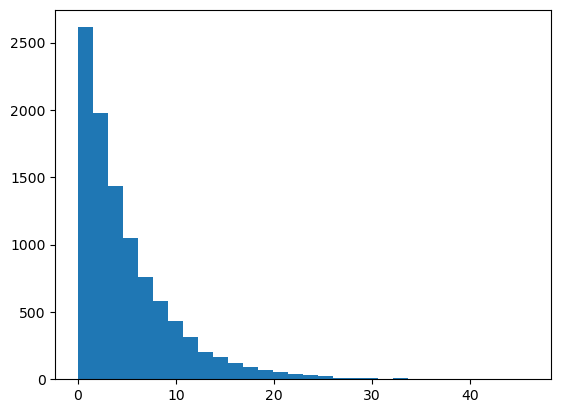

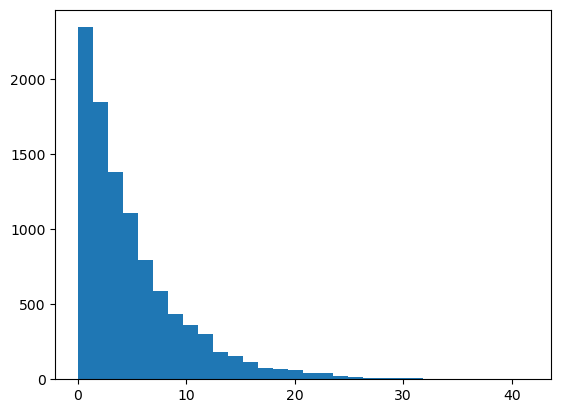

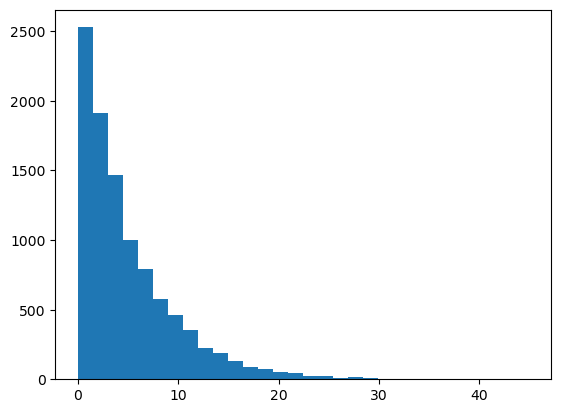

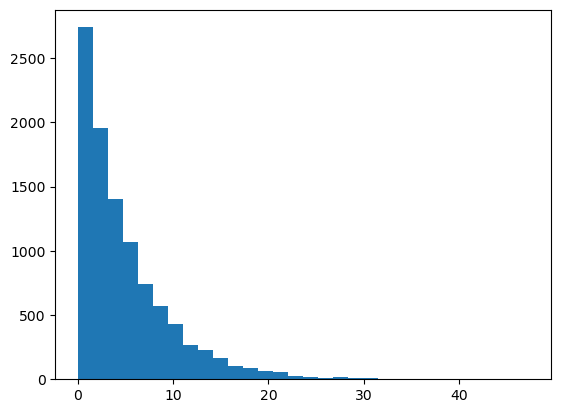

In [23]:
# Check Scenario class
import matplotlib.pyplot as plt

scenario = Scenario()
iat_dist = scenario.create_distributions()

for name, dist in iat_dist.items():
    print(f'{name} => {dist.exponential(1)}')
    print(f'{name} => {dist.normal(1)} \n')

for name, dist in iat_dist.items():
    vals = []
    for i in range(10000):
        val = dist.exponential(5)
        vals.append(val)
    plt.hist(vals, bins=30)
    plt.show()

**Reflection**

The LLM has added a Scenario class containing interarrival times and random seeds, as well as a way to create the rng for each patient type used for sampling the interarrival time. This can be used with any distribution to generate the same value from that distribution each time the code is ran. The test exapmle above uses the exponential distribution and plots the results. As the random seeds are set up inside the class, there is no way to change the output at this time.